# Singular Value Decomposition (SVD) algorithm  
Часто хочется сокращать размерность данных без особой возни с поиском параметров модели. Для этого можно использовать алгоритм SVD. Какие преимущества есть у него?  
1. Является важной методикой при анализе данных, а полученные в результате разложения матрицы имеют вполне осмысленную интерпретацию с точки зрения машинного обучения  
2. Его можно использовать для других алгоритмов (таких как PCA, например)  
3. SVD не ограничен размером матрицы, с которой он работает  
Однако, несмотря на преимущества, сингулярное разложение довольно медленное.  
  
Рассмотрим SVD с математической точки зреняи. Любая матрица (вещественная или комплексная) представляется в виде произведения трех матриц: $X = U\Sigma V^{*}$. U — унитарная матрица порядка m; Σ — матрица размера m x n, на главной диагонали которой лежат неотрицательные числа, называющиеся сингулярными (элементы вне главной диагонали равны нулю — такие матрицы иногда называют прямоугольными диагональными матрицами); V* — эрмитово-сопряжённая к V матрица порядка n. m столбцов матрицы U и n столбцов матрицы V называются соответственно левыми и правыми сингулярными векторами матрицы X. Для задачи редукции количества измерений именно матрица Σ, элементы которой, будучи возведенными во вторую степень, можно интерпретировать как дисперсию, которую «вкладывает» в общее дело каждая компонента, причем в убывающем порядке: σ1 ≥ σ2 ≥… ≥ σnoise.  
С точки зрения векторных преобразований декомпозиция хорошо расписана [здесь](https://towardsdatascience.com/singular-value-decomposition-example-in-python-dab2507d85a0) поэтому позволю себе не тратить время на переписывание матриц.  
  
У алгоритма SVD огромный спектр применения. Вот некоторые из задач: уменьшение размерности пространства, с которым мы работаем (напрмиер, для сжатия изображений, распознавания ключевых черт лиц); для дозаполнения матрицы (например, для восстановления изображений);  
  
Рассмотрим на примере с нашим любимым датасетом из изображений цифр

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")
X = mnist.data / 255.0
y = mnist.target
X.shape

(70000, 784)

In [18]:
X = X[:10000][:]
y = y[:10000]

<Figure size 432x288 with 0 Axes>

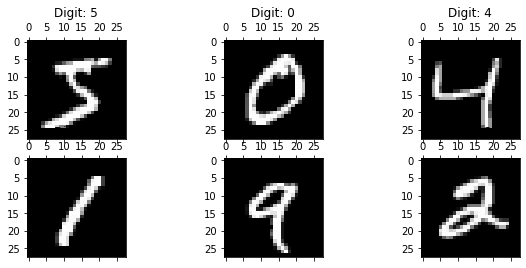

In [32]:
plt.gray()
fig = plt.figure(figsize=(10,4))
for i in range(0,6):
    ax = fig.add_subplot(2,3,i+1, title="Digit: {}".format(str(y[i])))
    ax.matshow(X[i][:].reshape((28, 28)))
plt.show()                         

Используя SVD попоробуем понять можем ли мы использовать только 2 характеристики для каждой строки для описания изображения.   
  
  Матрица s, возвращаемая функцией svd(), должна быть преобразована в диагональную матрицу с помощью метода diag. По умолчанию diag создаст матрицу n x n относительно исходной матрицы. Это вызывает проблему, поскольку размер матриц больше не следует правилу умножения матриц, где количество столбцов в матрице должно соответствовать количеству строк в другой матрице. Поэтому мы создаем новую матрицу m x n и заполняем первую ее часть n x n диагональной матрицей.

U размера (28, 28)
s размера (28,)
V размера (28, 28)



<Figure size 432x288 with 0 Axes>

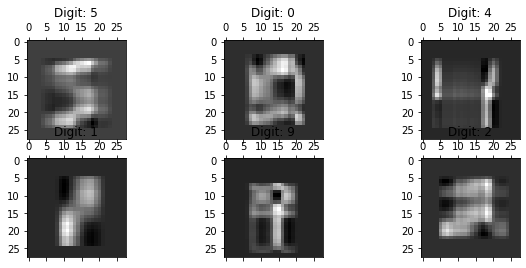

In [35]:
U, s_diag, V = np.linalg.svd(X[0].reshape((28,28)))
print(f'U размера {U.shape}')
print(f's размера {s_diag.shape}')
print(f'V размера {V.shape}')
print()

n_component = 2

plt.gray()
fig = plt.figure(figsize=(10,4))
for i in range(0,6):
    
    U, s_diag, V = np.linalg.svd(X[i].reshape((28,28)))
    S = np.zeros((image.shape[0], image.shape[1]))
    S[:image.shape[0], :image.shape[0]] = np.diag(s_diag)
    S = S[:, :n_component]
    VT = V[:n_component, :]
    
    ax = fig.add_subplot(2,3,i+1, title="Digit: {}".format(str(y[i])))
    ax.matshow(U.dot(S.dot(VT)), cmap='gray')
plt.show()                         

Сейчас цифры не похожи на себя, значит надо посмотреть на дисперсию и увеличить количество компонент.  
  
Вообще есть три способа использования SVD в Python.  
1. SVD in NumPy. Делает декомпозицибю матрицы. Чтобы получить нужное сокращение пространства до n_components необходимо проделать операции, как показано выше.  
2. Truncated SVD in scikit-learn. Наиболее распространенный в использовании, так как нам редко необъодимо видеть матрицы U,V,Sю Сразу трансофрмирует матрицу и сокращает размерность на указанное число n_components  
3. Randomized SVD in scikit-learn. Randomized SVD дает те же результаты, что и Truncated SVD, но быстрее вычисляется за счет использования методов апроксимации  
  
Давайте сравним точность модели случайного леса в случае, когда она обучается с использованием исходных рукописных цифр и когда она обучается с использованием сокращенного пространства признаков, полученного в результате Truncated SVD.  

In [36]:
time_start = time.time()
rf_original = RandomForestClassifier(oob_score=True)
rf_original.fit(X, y)
print(f'Time elapsed for Random Forest on mnist_digits: {time.time()-time_start} seconds')
print(f'Качество Random Forest на исходных картинках: {rf_original.oob_score_}')

Time elapsed for Random Forest on mnist_digits: 14.361399173736572 seconds
Качество Random Forest на исходных картинках: 0.9423


Time elapsed for TruncatedSVD with 2 components: 0.27854251861572266 seconds

X_reduced[0] = [6.49 -0.29]


<Figure size 432x288 with 0 Axes>

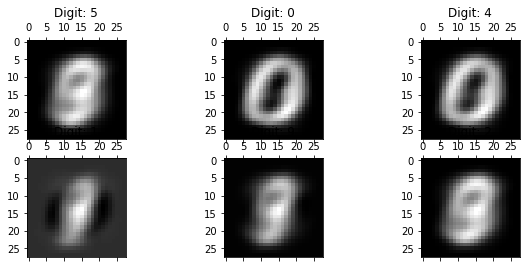

In [45]:
time_start = time.time()
svd_truncated = TruncatedSVD(n_components = 2)
X_reduced = svd_truncated.fit_transform(X)
print(f'Time elapsed for TruncatedSVD with 2 components: {time.time()-time_start} seconds')

print(f'\nX_reduced[0] = {X_reduced[0]}')

plt.gray()
fig = plt.figure(figsize=(10,4))
for i in range(0,6):
    ax = fig.add_subplot(2,3,i+1, title="Digit: {}".format(str(y[i])))
    ax.matshow((svd_truncated.inverse_transform(X_reduced[i].reshape(1,-1))).reshape((28,28)), cmap = 'gray')    
plt.show() 

Сейчас каждая картинка представлена двумя компонентами и как можно - хорошего качества ожидать не стоит. Цифры не похожи на самих себя при обратном преобразовании. Проверим качество Random Forest.

Скорее всего мы взяли слишком млао n_component. Мы можем проверить общую дисперсию, взяв сумму explained_variance_ratio_. Обычно мы стремимся к 80-90 процентам. Если дисперсия окажется маленькой - увеличим кол-во компонент.

In [46]:
time_start = time.time()
rf_reduced = RandomForestClassifier(oob_score=True)
rf_reduced.fit(X_reduced, y)
print(f'Time elapsed for Random Forest on SVD with 2 components: {time.time()-time_start} seconds')

print(f'Качество на Random Forest при SVD с n_components = 2: {rf_reduced.oob_score_}')

Time elapsed for Random Forest on SVD with 2 components: 4.315206050872803 seconds
Качество на Random Forest при SVD с n_components = 2: 0.3051


In [47]:
print(f'Дисперсия при n_components = 20: {svd_truncated.explained_variance_ratio_.sum()}')

Дисперсия при n_components = 20: 0.14491288082973172


Time elapsed for TruncatedSVD with 20 components: 0.4659583568572998 seconds
Дисперсия при n_components = 20: 0.6493770171232904
Time elapsed for Random Forest on SVD with 20 components: 9.213356733322144 seconds
Качество на Random Forest при SVD с n_components = 20: 0.9225


<Figure size 432x288 with 0 Axes>

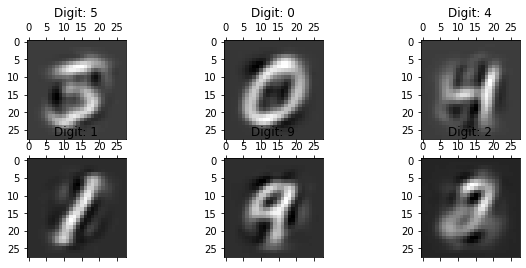

In [48]:
time_start = time.time()
svd_truncated = TruncatedSVD(n_components=20)
X_reduced = svd_truncated.fit_transform(X)
print(f'Time elapsed for TruncatedSVD with 20 components: {time.time()-time_start} seconds')
print(f'Дисперсия при n_components = 20: {svd_truncated.explained_variance_ratio_.sum()}\n')

time_start = time.time()
rf_reduced = RandomForestClassifier(oob_score=True)
rf_reduced.fit(X_reduced, y)
print(f'Time elapsed for Random Forest on SVD with 20 components: {time.time()-time_start} seconds')
print(f'Качество на Random Forest при SVD с n_components = 20: {rf_reduced.oob_score_}')

plt.gray()
fig = plt.figure(figsize=(10,4))
for i in range(0,6):
    ax = fig.add_subplot(2,3,i+1, title="Digit: {}".format(str(y[i])))
    ax.matshow((svd_truncated.inverse_transform(X_reduced[i].reshape(1,-1))).reshape((28,28)), cmap = 'gray')    
plt.show() 

Теперь стало лучше. Качество Random Forest высоко, близко к тому, которое было на непреобразованных данных. При этом мы сократили размерность пространства с 64 до 20, восстановленные картинки похожи на изначальные. То есть SVD сохранил достаточно информации об изначальном изображении  
  
При этом, вспомнив предыдущие наши ноутбуки, стоит заметить, что SVD работает намного быстрее предыдущих алгоритмов. Однако в целях визуализации чисто его лучше не использовать, так как на 2 или 3 компонентах он дает не точный результат. Я бы использовала его, а затем поверх, например, TSNE.

Ресурсы:   
[SVD](https://habr.com/ru/post/275273/)  
[об SVD в векторном виде и пример](https://towardsdatascience.com/singular-value-decomposition-example-in-python-dab2507d85a0)  
[О применении SVD с примерами, имплементацией и математическим объяснением](https://www.analyticsvidhya.com/blog/2019/08/5-applications-singular-value-decomposition-svd-data-science/)
